### Model Registry
How to run new models in a production environment? When a new model appears we may have the following questions:
- What has changed from the previous version of a model?
- Do I need to update hyperparameters of a new model?
- What is the model environment?
- Do I need to preprocess the data for a new model?
- What if a new model is bad...how to rollback to a previous one?


All that has been done before used Tracking Server (runs locally) and once we have some set of models we **can decide that some models ae ready for pruduction**. In this case we register "ready" models in `Model Registry`

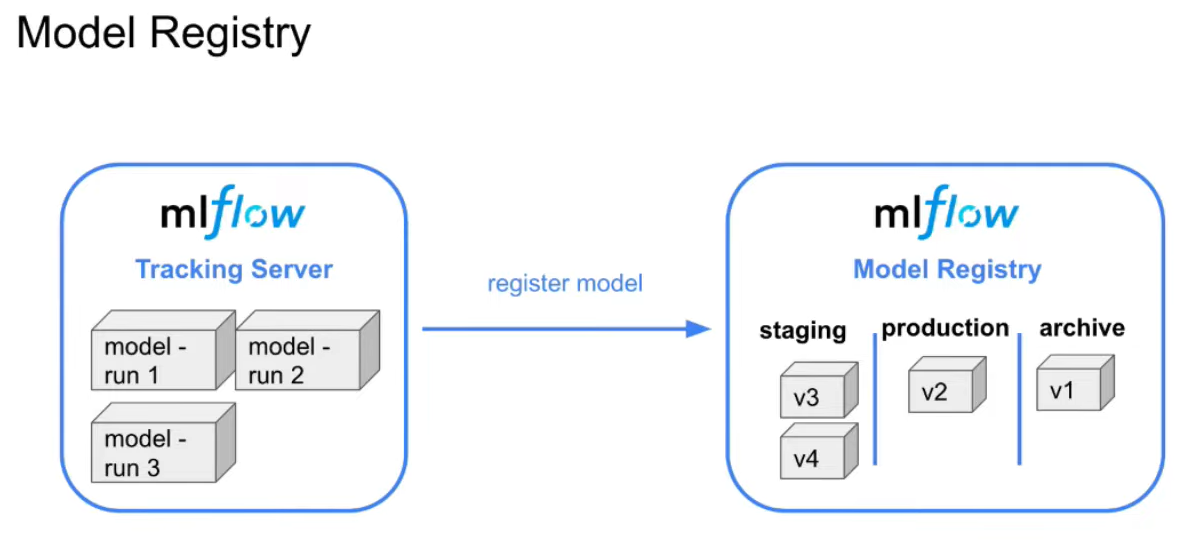

**Model Registry doesn't deploy any model. It only lists the models that are production-ready**

In [32]:
MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'

from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [2]:
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [4]:
# let's list all the experiments
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='experiment_1', tags={}>]

In [5]:
# Create a new experiment 
client.create_experiment(name='best_models_exp')

'2'

In [7]:
# Select runs 
runs = client.search_runs(experiment_ids='1',
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY, # only active runs (deleted runs are excluded)
                          max_results=5, # see only 5 runs 
                          order_by=['metrics.rmse_val ASC'])

In [31]:
# Show runs info
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse_val']:.4f}")

run id: ecfe56c274fa4a9b8959613d7106c848, rmse: 10.8127
run id: a8429de221ce4154923a9ad2c8dce145, rmse: 10.8127
run id: 563f97af033e47fe90de785490da4ffd, rmse: 10.8127
run id: 91d36ed0a1194b5b9da661e46f91e9d3, rmse: 10.8127
run id: ccbc078dd2b045e19ee21541e1817eb5, rmse: 10.8127


In [35]:
# Model Registry
run_id = 'ecfe56c274fa4a9b8959613d7106c848'
model_uri = f'runs:/{run_id}/artifacts'
mlflow.register_model(model_uri=model_uri, name='nyc-taxi-regressor')

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
2022/06/22 08:35:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 1
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1655912101801, current_stage='None', description=None, last_updated_timestamp=1655912101801, name='nyc-taxi-regressor', run_id='ecfe56c274fa4a9b8959613d7106c848', run_link=None, source='./mlruns/1/ecfe56c274fa4a9b8959613d7106c848/artifacts/artifacts', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [36]:
# Transition Between Stages
# list of registered models
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1655910501207, description='', last_updated_timestamp=1655910781184, latest_versions=[<ModelVersion: creation_timestamp=1655910501541, current_stage='Staging', description='', last_updated_timestamp=1655910781184, name='nyc-regressor', run_id='a8429de221ce4154923a9ad2c8dce145', run_link='', source='./mlruns/1/a8429de221ce4154923a9ad2c8dce145/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='nyc-regressor', tags={}>,
 <RegisteredModel: creation_timestamp=1655912043733, description=None, last_updated_timestamp=1655912101801, latest_versions=[<ModelVersion: creation_timestamp=1655912101801, current_stage='None', description=None, last_updated_timestamp=1655912101801, name='nyc-taxi-regressor', run_id='ecfe56c274fa4a9b8959613d7106c848', run_link=None, source='./mlruns/1/ecfe56c274fa4a9b8959613d7106c848/artifacts/artifacts', status='READY', status_message=None, tags={}, user_id=None, version=1>], na

In [39]:
model_name = 'nyc-regressor'
latest_version = client.get_latest_versions(name=model_name)
latest_version

[<ModelVersion: creation_timestamp=1655910501541, current_stage='Staging', description='', last_updated_timestamp=1655910781184, name='nyc-regressor', run_id='a8429de221ce4154923a9ad2c8dce145', run_link='', source='./mlruns/1/a8429de221ce4154923a9ad2c8dce145/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=1>]

In [40]:
# Transition Stag
client.transition_model_version_stage(
    name=model_name, 
    version=1,
    stage="Staging",
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1655910501541, current_stage='Staging', description='', last_updated_timestamp=1655912426512, name='nyc-regressor', run_id='a8429de221ce4154923a9ad2c8dce145', run_link='', source='./mlruns/1/a8429de221ce4154923a9ad2c8dce145/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=1>

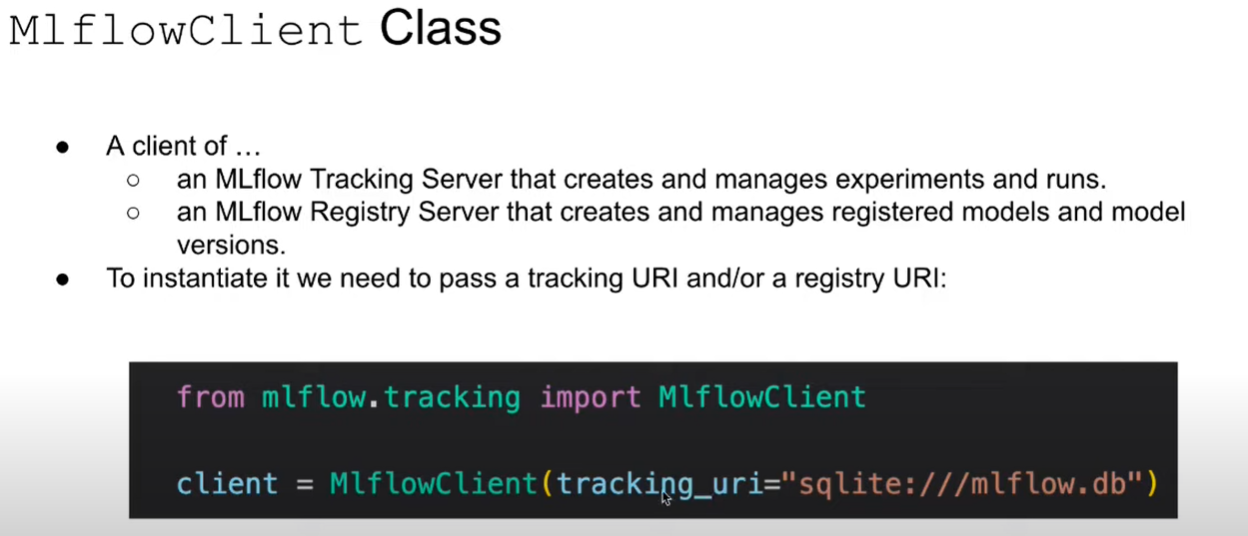